# Прогнозирование оттока клиентов оператора связи

### Описание задачи проекта
Оператору связи необходимо спрогнозировать отток абонентов. Если модель предскажет, что клиент хочет уйти, то ему будут предложены специальные уловия, от которых невозиожно отказаться. И клиент останется в компании.

#  1. Исследовательский анализ данных

## 1.1. Загрузка данных

Проект выпоняем в Colab, поэтому установим необходимые библиотеки.

In [ ]:
import pandas as pd
import numpy as np
import time
import shap
from scipy.stats import randint, spearmanr, wilcoxon, mannwhitneyu
import matplotlib.pyplot as plt
# from IPython.display import display
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score
# Импортируем функцию для стандартизации из библеотеки Sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
# Деревое решений
from sklearn.tree import DecisionTreeClassifier
# Случайный лес 
from sklearn.ensemble import RandomForestClassifier
# Логистическая регрессия
from sklearn.linear_model import LogisticRegression
from scipy.stats import uniform
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, EFstrType, Pool
from xgboost import XGBClassifier
# Метрики
from sklearn.metrics import roc_auc_score, accuracy_score, make_scorer, classification_report

In [ ]:
df_contract = pd.read_csv('contract.csv')
df_personal = pd.read_csv('personal.csv')
df_internet = pd.read_csv('internet.csv')
df_phone = pd.read_csv('phone.csv')

In [ ]:
print('\nИнформация о договоре')
display(df_contract.info())
print('\nПерсональные данные клиента')
display(df_personal.info())
print('\nИнформация об интернет-услугах')
display(df_internet.info())
print('\nИнформация об услугах телефонии')
display(df_phone.info())


Информация о договоре
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None


Персональные данные клиента
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None


Информация об интернет-услугах
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None


Информация об услугах телефонии
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

In [ ]:
print('\nИнформация о договоре')
display(df_contract)
print('\nПерсональные данные клиента')
display(df_personal)
print('\nИнформация об интернет-услугах')
display(df_internet)
print('\nИнформация об услугах телефонии')
display(df_phone)


Информация о договоре


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.5
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.9
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45
7041,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.6



Персональные данные клиента


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes
7039,2234-XADUH,Female,0,Yes,Yes
7040,4801-JZAZL,Female,0,Yes,Yes
7041,8361-LTMKD,Male,1,Yes,No



Информация об интернет-услугах


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...
5512,6840-RESVB,DSL,Yes,No,Yes,Yes,Yes,Yes
5513,2234-XADUH,Fiber optic,No,Yes,Yes,No,Yes,Yes
5514,4801-JZAZL,DSL,Yes,No,No,No,No,No
5515,8361-LTMKD,Fiber optic,No,No,No,No,No,No



Информация об услугах телефонии


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
...,...,...
6356,2569-WGERO,No
6357,6840-RESVB,Yes
6358,2234-XADUH,Yes
6359,8361-LTMKD,Yes


Мы имеем четыре таблицы с данными. Все данные в файлах без пропусков. 

1. "Информация о договоре" содержит 7043 наблюдений и 8 признаков:


- `customerID` - код клиента
- `BeginDate` - дата начала договора
- `EndDate` - дата окончания договора
- `Type` - тип оплаты (ежемесячно, ежегодно ...)
- `PaperlessBilling` - безбумажный биллинг
- `PaymentMethod` - метод оплаты
- `MonthlyCharges` - сумма ежемесячных платежей
- `TotalCharges` - итого расходов

2. "Персональные данные клиента" содержит 7043 наблюдений и 5 признаков:


 - `customerID` - код клиента
 - `gender` - пол клиента
 - `SeniorCitizen` - пожилой гражданин (Yes/No)
 - `Partner` - женат/замужем  (Yes/No)
 - `Dependents` - имеются иждивенцы   (Yes/No)


3. "Информация об интернет-услугах" содержит 5517 наблюдений и 8 признаков:


 - `customerID` - код клиента
 - `InternetService` - интернет услуги
 - `OnlineSecurity` - интернет-безопасность
 - `OnlineBackup`	- онлайн-резервное копирование
 - `DeviceProtection`	- защита устройства
 - `TechSupport` - техническая поддержка
 - `StreamingTV` - потоковое телевидение
 - `StreamingMovies` - потоковые фильмы

4. "Информация об услугах телефонии" содержит 6361 наблюдений и 2 признака:
- `customerID` - код клиента
- `MultipleLines` - несколько линий

## 1.2. Предобработка данных

Проверим данные на ошики выгрузки из базы данных

In [ ]:
print('Дублирующих строк 1 таблицы:', df_contract['customerID'].duplicated().sum())
print('Дублирующих строк 2 таблицы:', df_personal['customerID'].duplicated().sum())
print('Дублирующих строк 3 таблицы:', df_internet['customerID'].duplicated().sum())
print('Дублирующих строк 4 таблицы:', df_phone['customerID'].duplicated().sum())

Дублирующих строк 1 таблицы: 0
Дублирующих строк 2 таблицы: 0
Дублирующих строк 3 таблицы: 0
Дублирующих строк 4 таблицы: 0


In [ ]:
df_contract.head(1)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85


Зполним данные в столбце окончание контракта No на день актуальности данных 01 фев 2020

In [ ]:
df_contract['target'] = df_contract['EndDate']

df_contract.loc[df_contract['target'] == 'No', 'target'] = 0
df_contract.loc[df_contract['target'] != 0, 'target'] = 1
df_contract['target'] = df_contract['target'].astype(int)
df_contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,0
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,1


In [ ]:
df_contract['EndDate'].replace('No', '2020-02-01', inplace = True)
# df_contract

In [ ]:
df_contract['BeginDate'] = pd.to_datetime(df_contract['BeginDate'], 
                                        format='%Y-%m-%d')
df_contract['EndDate'] = pd.to_datetime(df_contract['EndDate'], 
                                        format='%Y-%m-%d')
display(df_contract)
df_contract.info()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.5,0
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1
...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,2020-02-01,One year,Yes,Mailed check,84.80,1990.5,0
7039,2234-XADUH,2014-02-01,2020-02-01,One year,Yes,Credit card (automatic),103.20,7362.9,0
7040,4801-JZAZL,2019-03-01,2020-02-01,Month-to-month,Yes,Electronic check,29.60,346.45,0
7041,8361-LTMKD,2019-07-01,2019-11-01,Month-to-month,Yes,Mailed check,74.40,306.6,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   object        
 8   target            7043 non-null   int64         
dtypes: datetime64[ns](2), float64(1), int64(1), object(5)
memory usage: 495.3+ KB


Создатим столбец с длительностью контракта, а признаки начало и окончание контракта удалим, так как для модели они не потребуются.

In [ ]:
df_contract['TotalCharges'] = df_contract['TotalCharges'].replace(' ', '')
df_contract['TotalCharges'].isna().sum()
print('Пропущенных значений в Итого расходов:',(df_contract['TotalCharges'] == '').sum())

Пропущенных значений в Итого расходов: 11


In [ ]:
df_contract['TotalCharges'] = pd.to_numeric(df_contract['TotalCharges'])
df_contract.info()
display(df_contract.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   target            7043 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int64(1), object(4)
memory usage: 495.3+ KB


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,0
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1


In [ ]:
df_contract['duration_contract'] = (df_contract['EndDate'] - df_contract['BeginDate'])

In [ ]:
df_contract['duration_contract'] = df_contract['duration_contract'] / np.timedelta64(1, 'm')
df_contract = df_contract.drop(['EndDate', 'BeginDate'], axis = 1)
df_contract.info()
df_contract.head(1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customerID         7043 non-null   object 
 1   Type               7043 non-null   object 
 2   PaperlessBilling   7043 non-null   object 
 3   PaymentMethod      7043 non-null   object 
 4   MonthlyCharges     7043 non-null   float64
 5   TotalCharges       7032 non-null   float64
 6   target             7043 non-null   int64  
 7   duration_contract  7043 non-null   float64
dtypes: float64(3), int64(1), object(4)
memory usage: 440.3+ KB


,customerID,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target,duration_contract
0,7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,29.85,0,44640.0


В данных всего оплат имеется 11 пропусков. Заполним пропуски умножением ежемесячного платежа на количство месяцев контракта.

In [ ]:
df_contract['TotalCharges'] = df_contract['TotalCharges'].fillna(df_contract['MonthlyCharges'] * df_contract['duration_contract'])

In [ ]:
print('Проверим данные на дубли и уникальность')
for i in (['Type',	'PaperlessBilling',	'PaymentMethod']):
  print('\n', df_contract[i].value_counts())

Проверим данные на дубли и уникальность

 Month-to-month    3875
Two year          1695
One year          1473
Name: Type, dtype: int64

 Yes    4171
No     2872
Name: PaperlessBilling, dtype: int64

 Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64


In [ ]:
df = (df_contract
      .merge(df_personal, on = 'customerID', how='left')
      .merge(df_internet, on = 'customerID', how='outer')
      .merge(df_phone, on = 'customerID', how='outer')
      )
display(df.head())
df.info()

,customerID,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target,duration_contract,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,29.85,0,44640.0,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,One year,No,Mailed check,56.95,1889.50,0,1491840.0,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,108.15,1,87840.0,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1840.75,0,1974240.0,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,Month-to-month,Yes,Electronic check,70.70,151.65,1,87840.0,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customerID         7043 non-null   object 
 1   Type               7043 non-null   object 
 2   PaperlessBilling   7043 non-null   object 
 3   PaymentMethod      7043 non-null   object 
 4   MonthlyCharges     7043 non-null   float64
 5   TotalCharges       7043 non-null   float64
 6   target             7043 non-null   int64  
 7   duration_contract  7043 non-null   float64
 8   gender             7043 non-null   object 
 9   SeniorCitizen      7043 non-null   int64  
 10  Partner            7043 non-null   object 
 11  Dependents         7043 non-null   object 
 12  InternetService    5517 non-null   object 
 13  OnlineSecurity     5517 non-null   object 
 14  OnlineBackup       5517 non-null   object 
 15  DeviceProtection   5517 non-null   object 
 16  TechSupport        5517 

Нам неизвестны. Попробуем пометить пропущенные значения 1 или 2, и как повлияет на качество моделей.

In [ ]:
df = df.fillna('No')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customerID         7043 non-null   object 
 1   Type               7043 non-null   object 
 2   PaperlessBilling   7043 non-null   object 
 3   PaymentMethod      7043 non-null   object 
 4   MonthlyCharges     7043 non-null   float64
 5   TotalCharges       7043 non-null   float64
 6   target             7043 non-null   int64  
 7   duration_contract  7043 non-null   float64
 8   gender             7043 non-null   object 
 9   SeniorCitizen      7043 non-null   int64  
 10  Partner            7043 non-null   object 
 11  Dependents         7043 non-null   object 
 12  InternetService    7043 non-null   object 
 13  OnlineSecurity     7043 non-null   object 
 14  OnlineBackup       7043 non-null   object 
 15  DeviceProtection   7043 non-null   object 
 16  TechSupport        7043 

In [ ]:
df = df.replace('Yes', 0).replace('No', 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customerID         7043 non-null   object 
 1   Type               7043 non-null   object 
 2   PaperlessBilling   7043 non-null   int64  
 3   PaymentMethod      7043 non-null   object 
 4   MonthlyCharges     7043 non-null   float64
 5   TotalCharges       7043 non-null   float64
 6   target             7043 non-null   int64  
 7   duration_contract  7043 non-null   float64
 8   gender             7043 non-null   object 
 9   SeniorCitizen      7043 non-null   int64  
 10  Partner            7043 non-null   int64  
 11  Dependents         7043 non-null   int64  
 12  InternetService    7043 non-null   object 
 13  OnlineSecurity     7043 non-null   int64  
 14  OnlineBackup       7043 non-null   int64  
 15  DeviceProtection   7043 non-null   int64  
 16  TechSupport        7043 

##1.3. Исследовательский анализ

### Построим гистограммы для количественных признаков

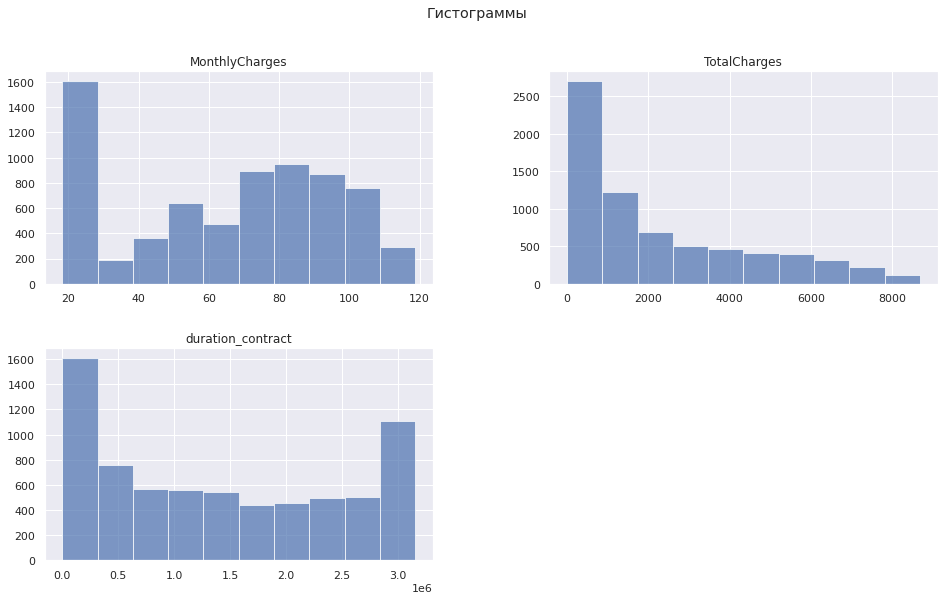

In [ ]:
sns.set()
df[['MonthlyCharges', 'TotalCharges', 'duration_contract']].hist(
    figsize = (16, 9), 
    # layout=(1,1), 
    alpha = 0.7)
plt.suptitle("Гистограммы")
# plt.xlabel("")
plt.ylabel("Количество наблюдений")
plt.show()

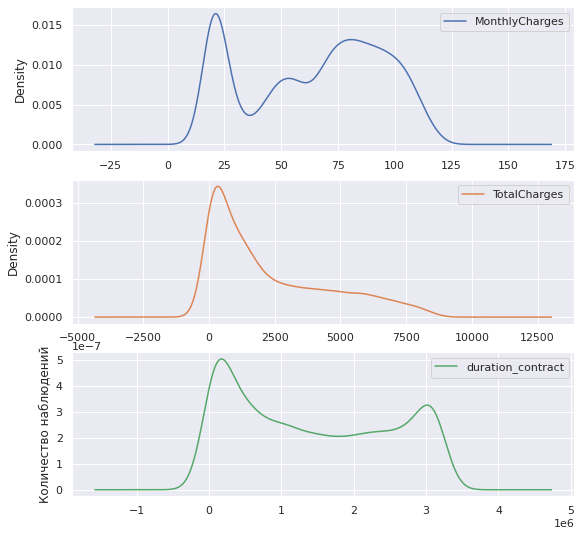

In [ ]:
df[['MonthlyCharges', 'TotalCharges', 'duration_contract']].plot(kind='density', subplots=True, 
        layout=(3,1), 
        sharex=False, 
        figsize = (9, 9)
        )
plt.ylabel("Количество наблюдений")
plt.show()


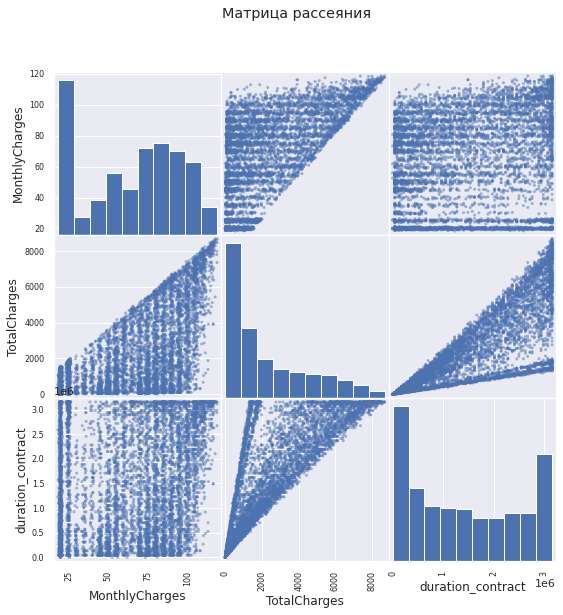

In [ ]:
pd.plotting.scatter_matrix(df[['MonthlyCharges', 'TotalCharges', 'duration_contract']], 
                           figsize= (9, 9))
plt.suptitle("Матрица рассеяния")
plt.show()

**Данные в количественных признаках распределены ненормально**

1.   Более половины клиентов получают электронные счета
2.   Ежемесячный платеж большинства абонентов около 25 евро
3. Большинство клиентов за время контракта заплатило около 2000 евро
4. Менее 2000 клиентов расторгло контракт (из 7043)
5. Около 1500 новых контрактов, более 1000 длительных контрактов 
6. Почти 6000 клиентов пенсионеры
7. Примерно половина клиентов в браке
8. Около 2000 человек имеют детей
9. Далее в данных примерно одинаковые распределения (интернет-услуги)



### Построим боксплоты для выявления выбросов

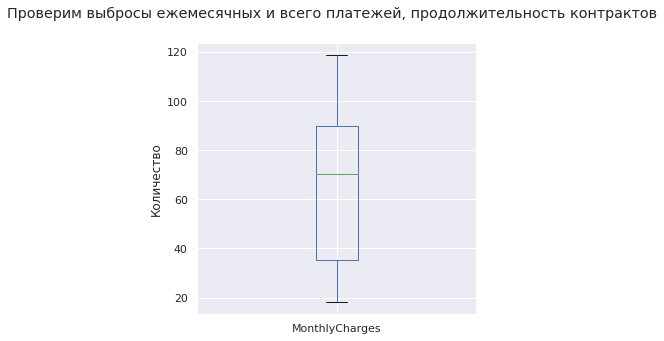

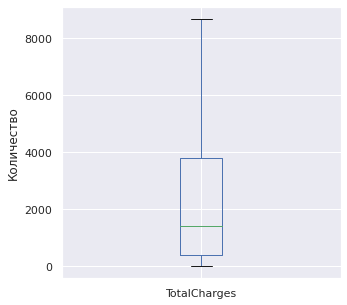

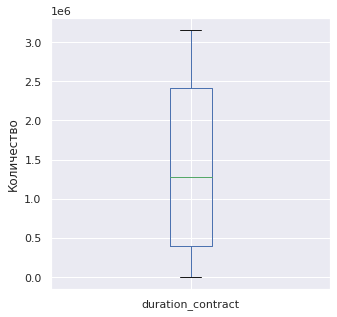

In [ ]:
plt.figure(figsize=(20,10))
plt.suptitle("Проверим выбросы ежемесячных и всего платежей, продолжительность контрактов")
for i in (['MonthlyCharges',	'TotalCharges',	'duration_contract']):
  df[i].plot(kind='box', figsize = (5, 5))
  # plt.xlabel(i)
  plt.ylabel('Количество')
  print('\n')
  plt.show()

Данные не имеют выбросов

### Выявим зависисмость количественных данных

Так как данные распределены ненормально, то будем использовать корреляцию Спирмена

In [ ]:
(df[['MonthlyCharges', 'TotalCharges', 'duration_contract']]).corr('spearman')

,MonthlyCharges,TotalCharges,duration_contract
MonthlyCharges,1.000000,0.638028,0.273912
TotalCharges,0.638028,1.000000,0.888753
duration_contract,0.273912,0.888753,1.000000


Построим тепловую диаграмму для наглядности

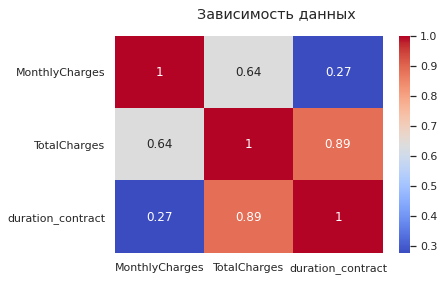

In [ ]:
sns.heatmap(df[['MonthlyCharges', 'TotalCharges', 'duration_contract']].corr('spearman'), annot = True, cmap= 'coolwarm')
plt.suptitle("Зависимость данных")
plt.show()

Имеется мультиколлинеарность между:
 1. ежемесячными платежами и общими платежами
 2. продолжительностью контракта и общими платежами (более высокая)
 
Зависимые признаки не нужно подавать в обучение моделей

### Проверим гипотезы

Формулирование критерия для исследования данных: 

Мы имеем количественные данные (Оплаты), которые не подчиняются закону нормального распределения, данные независимые, сравниваем две группы (target 0 и 1. Используем критерий Манна-Уитни.
Предположение по умолчанию для теста, нулевая гипотеза, состоит в том, что два образца имеют одинаковое распределение.

- Не в состоянии отклонить H0: Распределения выборки равны.
- Отклонить H0: Распределения выборки не равны.

In [ ]:
data1 = df.loc[df['target'] == 0, 'TotalCharges']
data2 = df.loc[df['target'] == 1, 'TotalCharges']

In [ ]:
# compare samples
stat, p = mannwhitneyu(data1, data2, alternative='two-sided')
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Same distribution (fail to reject H0)')
else:
	print('Different distribution (reject H0)')

Statistics=6288982.000, p=0.000
Different distribution (reject H0)


Отвергаем нулевую гипотезу: Распределения выборки различаются.

# Список уточняющих вопросов



1.   Правильно ли заполнить пропуски по услугам "неизвестно" ?
2.   Признаки начиная с дополнительные интернет-услуги рапределены примерно одинаково. Нужно ли их все использовать для обучения модели (зависимые признаки)? Может достаточно одних данных из таблицы "Контракт"?
3. Иммеет ли смысл пробовать классические модели или лучше все время уделить тюнингу моделей градиентного бустинга?



# Примерный план решения задачи. Пропишите 3–5 основных шагов, каждый поясните не более двумя предложениями

Наша задача бинарной классификации. Наш целевой признак с нами клиент - 0 или нет - 1 (столбец `target`)
1.   Подготовку признаков проведем техникой прямого кодирования (One-Hot Encoding), кроме бустингов, которые работаю с категориями

2. Подготовим данные на тренировочную, валидационную и тестовую выборки (соотношение 60-20-20)
3. Применим стандартизацию (масштабирование), балансирование для классических моделей, увеличение выборки
4. Будем обучать категориальные алгоритмы: 
  - Случайный лес для классификации
  - Логистическую регрессию 
  - Бустинги (CatBoostClassifier, LGBMClassifier, XGBClassifier)

5. Качество моделей измеряем метрикой ROC-AUC, дополнительно вывод метрики accuracy




# 2. Подготовка данных

Удалим признак `customerID`, который не несет ценности для обучения и зависимые признаки, которые могут повлиять на качество модели.

In [ ]:
df_cat = df

In [ ]:
df = df.drop(['customerID',
              'TotalCharges',
              'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'
              ], axis = 1)

Подготовку признаков проведем техникой прямого кодирования (One-Hot Encoding). Преобразуем категориальные признаки  в численные, что позволит нам использовать модели: DecisionTreeClassifier, RandomForestClassifier, LogisticRegression, XGBClassifier, которые не могут работать с категориальными признаками.

Чтобы избежать ловушку фиктивных признаков (дамми-ловушку), добавим аргумент drop_first, который удалит первую колонку у каждого из признаков.

In [ ]:
print('Размер таблицы до прямого кодирования:', df.shape )
df = pd.get_dummies(df, drop_first = True)
print()
print('Размер таблицы после прямого кодирования:', df.shape )
print('\nТаблица после прямого кодирования')
display(df.head())

Размер таблицы до прямого кодирования: (7043, 12)

Размер таблицы после прямого кодирования: (7043, 16)

Таблица после прямого кодирования


,PaperlessBilling,MonthlyCharges,target,duration_contract,SeniorCitizen,Partner,Dependents,MultipleLines,Type_One year,Type_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,gender_Male,InternetService_DSL,InternetService_Fiber optic
0,0,29.85,0,44640.0,0,0,1,1,0,0,0,1,0,0,1,0
1,1,56.95,0,1491840.0,0,1,1,1,1,0,0,0,1,1,1,0
2,0,53.85,1,87840.0,0,1,1,1,0,0,0,0,1,1,1,0
3,1,42.30,0,1974240.0,0,1,1,1,1,0,0,0,0,1,1,0
4,0,70.70,1,87840.0,0,1,1,1,0,0,0,1,0,0,0,1


## 2.1. Разобьём данные на выборки

В нашей задаче не предоставлена тестовая выборка, поэтому существющие данные мы делим на три выборки:

- Обучающая выборка 60% от исходных данных, для обучения модели
- Валидационная выборка 20% от исходных данных, для выбора лучшего алгоритма и оптимальных параметров
- Тестовая выборка 20% для финального теста лучшей модели

In [ ]:
train, test = train_test_split(df, test_size = 0.2, random_state = 12345)

Разделим данные на таблицы с признаками и целевым признаком:

- target_train - Целевой признак тренировочной выборки

- target_test - Целевой признак тестовой выборки
- features_train - Признаки тренировочной выборки

- features_test - Признаки тестовой выборки

In [ ]:
target_train = train['target']
target_test = test['target']
features_train = train.drop('target', axis = 1)
features_test = test.drop('target', axis = 1)

# Проверим размеры созданных выборок
print('\nРазмер таблицы "Целевой признак тренировочной выборки":', target_train.shape)
print('Размер таблицы "Целевой признак тестовой выборки":', target_test.shape)
print('Размер таблицы "Признаки тренировочной выборки":', features_train.shape)
print('Размер таблицы "Признаки тестовой выборки":', features_test.shape)


Размер таблицы "Целевой признак тренировочной выборки": (5634,)
Размер таблицы "Целевой признак тестовой выборки": (1409,)
Размер таблицы "Признаки тренировочной выборки": (5634, 15)
Размер таблицы "Признаки тестовой выборки": (1409, 15)


## 2.2. Масштабирование признаков

Если в данных присутствуют колличественные признаки с разными
разбросами значений, то алгорим может решить, что признаки с
большими значениями и разбросом важнее. Чтобы избежать этой
ловушки, признаки масштабируются — приводятся к одному масштабу.

Один из методов масштабирования — стандартизации данных.

In [ ]:
# Создадим переменную со списком числовых признаков
numeric = ['MonthlyCharges', 
           'duration_contract']
# Обучим стандартизацию на тренировочной выборки
scaler = StandardScaler()
scaler.fit(features_train[numeric])

StandardScaler(copy=True, with_mean=True, with_std=True)

Преобразуем обучающую, тестовую выборки функцией transform(). Изменённые наборы сохраним в переменных:

In [ ]:
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])
print('\nМасштабированные численные признаки обучающей выборки')
display(features_train.head())
print('\nМасштабированные численные признаки тестовой выборки')
display(features_test.head())


Масштабированные численные признаки обучающей выборки


,PaperlessBilling,MonthlyCharges,duration_contract,SeniorCitizen,Partner,Dependents,MultipleLines,Type_One year,Type_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,gender_Male,InternetService_DSL,InternetService_Fiber optic
1580,1,0.227892,-0.467212,1,0,1,0,1,0,0,0,0,0,1,0
2902,0,0.307749,-1.081316,1,1,1,1,0,0,0,1,0,0,0,1
410,0,0.548983,-1.204943,1,1,1,0,0,0,0,1,0,1,0,1
6098,0,0.367642,-0.467212,0,0,0,0,1,0,0,0,0,1,1,0
2930,1,-1.301034,-0.058705,0,0,0,0,0,1,0,0,1,1,0,0



Масштабированные численные признаки тестовой выборки


,PaperlessBilling,MonthlyCharges,duration_contract,SeniorCitizen,Partner,Dependents,MultipleLines,Type_One year,Type_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,gender_Male,InternetService_DSL,InternetService_Fiber optic
1128,0,-1.512322,-0.223990,0,1,1,1,0,0,0,1,0,1,0,0
2875,0,0.673760,-0.430930,0,0,1,0,0,0,0,1,0,1,0,1
1783,0,0.226228,-1.288257,0,1,0,1,0,0,0,1,0,1,0,1
3804,1,0.499073,-0.917376,0,1,1,0,0,0,0,1,0,1,0,1
6087,0,-0.828548,-0.264303,0,1,0,1,1,0,0,0,0,1,1,0


Мы получили масштабированные (стандартизированные) признаки для трёх выборок.

Чтобы оценить адекватность модели, проверим, как часто в целевом признаке встречается класс «1» или «0». Количество уникальных значений подсчитывается методом value_counts(). Он группирует строго одинаковые величины.


Соотношение классов целевого признака в исходных данных
0    0.735534
1    0.264466
Name: target, dtype: float64



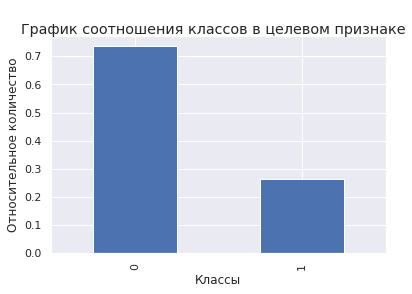

In [ ]:
print('\nСоотношение классов целевого признака в исходных данных')
class_frequency = target_train.value_counts(normalize=True)
print(class_frequency)
print()
class_frequency.plot(kind = 'bar', grid=True)
plt.suptitle("\nГрафик соотношения классов в целевом признаке")
plt.xlabel("Классы")
plt.ylabel("Относительное количество")
plt.show()

Большая разница между классами 74 на 26 %.
В моделях будем использовать балансирование весов классов.

**Увеличение выборки**

Сделаем объекты нечастого класса более частыми

Преобразование проходит в несколько этапов:
- Разделить обучающую выборку на отрицательные и положительные объекты;
- Скопировать несколько раз положительные объекты;
- С учётом полученных данных создать новую обучающую выборку;
- Перемешать данные: идущие друг за другом одинаковые вопросы не помогут обучению.
- Скопировать объекты несколько раз поможет синтаксис умножения списков в Python. Чтобы повторить элементы списка, он умножается на число (нужное количество раз)

Подберем множитель (сколько раз скопировать объекты для увеличение выборки

In [ ]:
# # Мы разделим обучающую выборку на отрицательные и положительные объекты.
# def upsample(features, target, repeat):
#     """Функция принимаем значение признаков (features[]), целевого признака (target[]), repeat(int / float), "
#     " класс который будет увеличен (upsampled_сlass (0 or 1))"""
#     features_zeros = features_train[target == 0]
#     features_ones = features_train[target == 1]
#     target_zeros = target_train[target == 0]
#     target_ones = target_train[target == 1]

#     features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
#     target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
#     features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)
    
#     return features_upsampled, target_upsampled

# # Циклом произведем подбор множителя
# for repeat in range(0, 5, 1):
#     features_upsampled, target_upsampled = upsample(features_train, target_train, repeat)
    
#     predicted_valid = pd.Series(model_forest.predict(features_upsampled))
#     class_frequency = predicted_valid.value_counts(normalize = True)
#     print("repeat =", repeat, end = '')
#     print()
#     print(class_frequency)
#     print()

In [ ]:
# Мы разделим обучающую выборку на отрицательные и положительные объекты.
def upsample(features, target, repeat):
    """Функция принимаем значение признаков (features[]), целевого признака (target[]), repeat(int / float), "
    " класс который будет увеличен (upsampled_сlass (0 or 1))"""
    features_zeros = features_train[target == 0]
    features_ones = features_train[target == 1]
    target_zeros = target_train[target == 0]
    target_ones = target_train[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled
    
    
features_train, target_train = upsample(features_train, target_train, 3) # Используем множитель 
# features_train.shape

Проверим соотношение классов после увеличении выборки

Соотношение классов целевого признака после увеличении выборки

Соотношение классов в целевом признаке
1    0.518923
0    0.481077
Name: target, dtype: float64



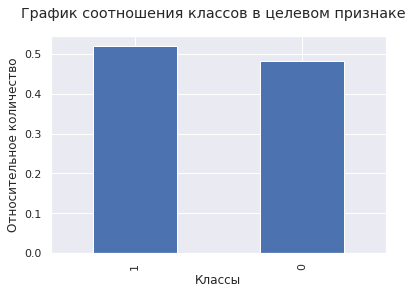

In [ ]:
print('Соотношение классов целевого признака после увеличении выборки')
class_frequency = target_train.value_counts(normalize=True)
print('\nСоотношение классов в целевом признаке')
print(class_frequency)
print()
class_frequency.plot(kind = 'bar', grid=True)
plt.suptitle("График соотношения классов в целевом признаке")
plt.xlabel("Классы")
plt.ylabel("Относительное количество")
plt.show()

# 3. Обучение моделей

## 3.1. DecisionTreeClassifier

In [ ]:
# %%time
# tree = DecisionTreeClassifier(class_weight='balanced', random_state=12345)

# parameters  = {"max_depth": range(1, 50, 5),
#               "max_features": range(1, 20),
#               "criterion": ["gini", "entropy"]
#                }

# tree_cv  = GridSearchCV(tree, parameters, verbose=10, n_jobs = -1, scoring = 'roc_auc', cv =9)
# tree_cv.fit(features_train, target_train)
# tree_best = tree_cv.best_params_
# tree_best_score = tree_cv.best_score_
# print("\nTuned Decision Tree Parameters: {}".format(tree_best))
# print("Best score is {}".format(tree_best_score))

Tuned Decision Tree Parameters: {'criterion': 'gini', 'max_depth': 26, 'max_features': 13}
Best score is 0.9224696846857418

Обучим модель и сделаем предсказание на валидационной выборки

In [ ]:
%%time
model_tree = DecisionTreeClassifier(criterion= 'gini', max_depth= 26, max_features= 13, 
                                    class_weight='balanced', random_state=12345)
model_tree.fit(features_train, target_train)
predictions_test = model_tree.predict_proba(features_test)[:,1]
tree_roc_auc_score = roc_auc_score(target_test, predictions_test)
print('\nМетрика на тестовой выбрке DecisionTreeClassifier roc_auc_score:', tree_roc_auc_score)
predictions_test = model_tree.predict(features_test)
print("Метрика на Тестовой выбрке DecisionTreeClassifier accuracy_score:", 
      accuracy_score(target_test, predictions_test))


Метрика на тестовой выбрке DecisionTreeClassifier roc_auc_score: 0.7202269641622051
Метрика на Тестовой выбрке DecisionTreeClassifier accuracy_score: 0.7799858055358411
CPU times: user 38 ms, sys: 1.12 ms, total: 39.1 ms
Wall time: 41.8 ms


### Метрика модели DecisionTreeClassifier
- roc_auc_score: 0.72
- accuracy_score: 0.77

## 3.2. RandomForestClassifier

In [ ]:
# %%time
# clf = RandomForestClassifier(class_weight='balanced', random_state=12345)
# parameter = {
#     # 'bootstrap': [True, False],
#     'max_depth': [1, 10, 20, 30, 40, 50, None],
#     'max_features': ['auto', 'sqrt'],
#     'min_samples_leaf': [1, 2, 4],
#     'min_samples_split': [2, 5, 10],
#     'n_estimators': [1500, 2000, 3000]
#     }
# searcher = RandomizedSearchCV(clf, parameter, verbose=10, n_jobs = -1, scoring = 'roc_auc', n_iter=100, cv = 7)
# searcher.fit(features_train, target_train)
# clf_best = searcher.best_params_
# best_score = searcher.best_score_
 
# print('Best params = ', clf_best)
# print('best_score = ', best_score)

In [ ]:
# %%time
# clf = RandomForestClassifier(class_weight='balanced', random_state=12345)

# parameter_grid = {
#             'max_depth': [1, 10, 20, 30, 40, 50, None],
#  'max_features': ['auto', 'sqrt'],
#  'min_samples_leaf': [1, 2, 4],
#  'min_samples_split': [2, 5, 10],
#  'n_estimators': [500, 1500]
#         }

# grid_searcher = GridSearchCV(clf, parameter_grid, verbose=10, n_jobs = -1)
# grid_searcher.fit(features_train, target_train)
# clf_best = grid_searcher.best_estimator_
 
# print('Best params = ', clf_best.get_params())

Обучим модель RandomForestClassifier и сделаем предсказания

In [ ]:
%%time
model_forest = RandomForestClassifier(n_estimators= 1500, min_samples_split= 5, 
                                      min_samples_leaf= 4, max_features= 'auto', 
                                      max_depth= 10, class_weight='balanced', random_state=12345)
model_forest.fit(features_train, target_train)
predictions_test = model_forest.predict_proba(features_test)
forest_roc_auc_score = roc_auc_score(target_test, predictions_test[:,1])
print('\nМетрика на тестовой выбрке RandomForestClassifier roc_auc_score:', forest_roc_auc_score)
predictions_test = model_tree.predict(features_test)
print("Метрика на Тестовой выбрке RandomForestClassifier accuracy_score:", 
      accuracy_score(target_test, predictions_test))


Метрика на тестовой выбрке RandomForestClassifier roc_auc_score: 0.8556894740886852
Метрика на Тестовой выбрке RandomForestClassifier accuracy_score: 0.7799858055358411
CPU times: user 8.88 s, sys: 108 ms, total: 8.99 s
Wall time: 9.02 s


### Метрика модели RandomForestClassifier
- roc_auc_score: 0.85
- accuracy_score: 0.77

## 3.3. LogisticRegression

In [ ]:
# %%time
# logistic = LogisticRegression(class_weight='balanced', solver = 'liblinear')
# # Create regularization penalty space
# penalty = ['l1', 'l2']

# # Create regularization hyperparameter distribution using uniform distribution
# C = uniform(loc=0, scale=4)

# # Create hyperparameter options
# hyperparameters = dict(C=C, penalty=penalty)
# # Create randomized search 5-fold cross validation and 100 iterations
# clf = RandomizedSearchCV(logistic, hyperparameters, random_state=12345, scoring = 'roc_auc', 
#                          n_iter=100, cv=9, verbose=10, n_jobs=-1)
# # Fit randomized search
# best_model = clf.fit(features_train, target_train)
# # View best hyperparameters
# print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
# print('Best C:', best_model.best_estimator_.get_params()['C'])
# clf_best = best_model.best_params_
# best_score = best_model.best_score_
 
# print('Best params = ', clf_best)
# print('best_score = ', best_score)

Best Penalty: l1
Best C: 0.313037134008856
Best params =  {'C': 0.313037134008856, 'penalty': 'l1'}
best_score =  0.8387372641240588
CPU times: user 2.46 s, sys: 139 ms, total: 2.6 s
Wall time: 30.7 s

In [ ]:
model_logistic = LogisticRegression(class_weight='balanced',
                                    max_iter = 100,
                                    penalty = 'l1',
                                    C = 0.313,
                                    solver = 'liblinear',
                                    random_state=12345)
model_logistic.fit(features_train, target_train)

predicted_test = model_logistic.predict_proba(features_test)
print("Метрика на Тестовой выбрке LogisticRegression roc_auc_score:", 
      roc_auc_score(target_test, predicted_test[:,1]))
predicted_test = model_logistic.predict(features_test)
print("Метрика на Тестовой выбрке LogisticRegression accuracy_score:", 
      accuracy_score(target_test, predicted_test))

Метрика на Тестовой выбрке LogisticRegression roc_auc_score: 0.8400030740067117
Метрика на Тестовой выбрке LogisticRegression accuracy_score: 0.7423704755145494


### Метрика модели  LogisticRegression:
- roc_auc_score: 0.84
- accuracy_score: 0.74

## 3.4. XGBClassifier

In [ ]:
# %%time
# clf = XGBClassifier(n_estimators=3000, objective='binary:logistic',
#                     silent=True, nthread=6, eval_metric='auc', 
#                     # tree_method='gpu_hist',
#                     random_state=12345
#                     )

# params = {
#         'min_child_weight': [1, 5, 10],
#         # 'gamma': [0.5, 1, 1.5, 2, 5],
#         # 'subsample': [0.6, 0.8, 1.0],
#         # 'colsample_bytree': [0.6, 0.8, 1.0],
#         'max_depth': [3, 5, 7, 10],
#         # 'learning_rate': [0.01, 0.02, 0.03]
#         }

# gs_clf = RandomizedSearchCV(clf, params, 
#                            random_state=12345, scoring = 'roc_auc', 
#                            n_iter=100, cv=9, verbose=10, n_jobs=-1
#                             )
# gs_clf.fit(features_train, target_train)
# best_score = gs_clf.best_score_
# best_params = gs_clf.best_params_

# print("Best score: {}".format(best_score))
# print("Best params: {}".format(best_params))

- Best score: 0.9883162746394366
- Best params: {'min_child_weight': 1, 'max_depth': 10}
- CPU times: user 1min 14s, sys: 5.49 s, total: 1min 19s
- Wall time: 44min 18s

In [ ]:
%%time
model_XGBoost = XGBClassifier(
                              n_estimators = 3000, 
                              max_depth= 10,
                              # min_child_weight = 3,
                              n_jobs= -1, 
                              learning_rate = 0.04,
                              min_child_weight=1,
                              # gamma=0,
                              # reg_lambda= 0.1,
                              # subsample=0.6,
                              # colsample_bylevel= 1.0,
                              # colsample_bytree=0.4,
                              objective= 'binary:logistic',
                              nthread = 6,
                              # scale_pos_weight=1,
                              # seed=27,
                              # max_delta_step = 1,
                              eval_metric='auc',
                              silent=True,
                              random_state=12345
                              )
model_XGBoost.fit(features_train, target_train)

predicted_test = model_XGBoost.predict_proba(features_test)
print("\nМетрика на Тестовой выборке XGBoost roc_auc_score:", 
      roc_auc_score(target_test, predicted_test[:,1]))
predicted_test = model_XGBoost.predict(features_test)
print("\nМетрика на Тестовой выбрке XGBoost accuracy_score:", 
      accuracy_score(target_test, predicted_test))
print('')
print(classification_report(target_test, predicted_test) )
print('')


Метрика на Тестовой выборке XGBoost roc_auc_score: 0.902988190690883

Метрика на Тестовой выбрке XGBoost accuracy_score: 0.8630234208658624

              precision    recall  f1-score   support

           0       0.90      0.92      0.91      1030
           1       0.76      0.71      0.74       379

    accuracy                           0.86      1409
   macro avg       0.83      0.82      0.82      1409
weighted avg       0.86      0.86      0.86      1409


CPU times: user 1min 14s, sys: 5.4 s, total: 1min 19s
Wall time: 42.9 s


### Метрика модели XGBClassifier 
- roc_auc_score: 0.90
- accuracy_score: 0.86





## 3.5. LGMBClassifier

In [ ]:
# %%time

# from scipy.stats import randint as sp_randint
# from scipy.stats import uniform as sp_uniform
# param_test ={'num_leaves': range(2, 5, 1), 
#              'min_child_samples': range(1, 10), 
#              'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
#              'subsample': np.arange(0.01, 1, 0.01), 
#              'colsample_bytree': np.arange(0.01, 1, 0.01),
#              'reg_alpha': [0, 1e-1, 1, 2, 3],
#              'reg_lambda': [0, 1e-1, 1, 2, 3],
#              }


# #n_estimators is set to a "large value". The actual number of trees build will depend on early stopping and 5000 define only the absolute maximum
# clf = LGBMClassifier(objective = 'binary', max_depth=-1, random_state=12345, 
#                      silent=True, metric='None', 
#                      n_jobs=-1, n_estimators = 8000,
#                      class_weight = 'balanced')
# gs = RandomizedSearchCV(
#     estimator=clf, param_distributions=param_test, 
#     scoring='roc_auc',
#     cv=5,
#     refit=True,
#     n_iter=100,    
#     verbose=10)

# gs.fit(features_train, target_train)
# print('Best score reached: {} with params: {} '.format(gs.best_score_, gs.best_params_))


- Best score reached: 0.9758884281459126 
- with params: {'subsample': 0.73, 'reg_lambda': 1, 'reg_alpha': 0, 'num_leaves': 4, 'min_child_weight': 0.001, 'min_child_samples': 4, 'colsample_bytree': 0.97} 
- CPU times: user 1h 34min 38s, sys: 19min 25s, total: 1h 54min 4s
Wall time: 1h 3min 33s


In [ ]:
%%time
model_LGBM = LGBMClassifier(
                          objective = 'binary',
                          n_estimators = 8000, # 8000
                           max_depth = -1, 
                           num_leaves = 4,
                           min_data_in_leaf = 10, 
                           learning_rate= 0.1,
                           random_state = 12345,
                          #  subsample_freq = 10,
                          #  device = 'gpu',
                            class_weight = 'balanced',
                            n_jobs= -1,
                            colsample_bytree= 0.97,
                            min_child_weight= 0.001,
                            min_child_samples= 4,
                            reg_alpha= 0, 
                            reg_lambda= 1,
                            # max_bin = 500,
                            # min_data_in_bin = 3,
                            # min_sum_hessian_in_leaf = 1
                            subsample= 0.73
                            )
model_LGBM.fit(features_train, target_train)
predicted_test = model_LGBM.predict_proba(features_test)[:,1]
print("\nМетрика на Тестовой выбрке LGBM roc_auc_score:", 
      roc_auc_score(target_test, predicted_test))
predicted_test = model_LGBM.predict(features_test)
print("\nМетрика на Тестовой выборке LGBM accuracy_score:", 
      accuracy_score(target_test, predicted_test) )
print('')
print(classification_report(target_test, predicted_test) )
print('')


Метрика на Тестовой выбрке LGBM roc_auc_score: 0.9333875553961626

Метрика на Тестовой выборке LGBM accuracy_score: 0.8687012065294535

              precision    recall  f1-score   support

           0       0.93      0.89      0.91      1030
           1       0.73      0.81      0.77       379

    accuracy                           0.87      1409
   macro avg       0.83      0.85      0.84      1409
weighted avg       0.87      0.87      0.87      1409


CPU times: user 20.3 s, sys: 4.15 s, total: 24.5 s
Wall time: 13.5 s


### Метрики на модели LGBMClassifier
- roc_auc_score: 0.93
- accuracy_score: 0.86

## 3.6. CatBoostClassifier

In [ ]:
# Передподготовим данные для модели, так как она выдет качество ваше, если ей подавать категориальные признаки
df_cat = df_cat.drop(['customerID',
                      'TotalCharges',
                    # 'OnlineSecurity', 'OnlineBackup','DeviceProtection', 
                    # 'TechSupport', 'StreamingTV', 'StreamingMovies'
                      ], axis = 1)
train, test = train_test_split(df_cat, test_size = 0.2, random_state = 12345)
target_train = train['target']
target_test = test['target']
features_train = train.drop('target', axis = 1)
features_test = test.drop('target', axis = 1)
numeric = ['MonthlyCharges', 'duration_contract']
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])
def upsample(features, target, repeat):
    """Функция принимаем значение признаков (features[]), целевого признака (target[]), repeat(int / float), "
    " класс который будет увеличен (upsampled_сlass (0 or 1))"""
    features_zeros = features_train[target == 0]
    features_ones = features_train[target == 1]
    target_zeros = target_train[target == 0]
    target_ones = target_train[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled
    
features_train, target_train = upsample(features_train, target_train, 3)

In [ ]:
# %%time
# cat_features = ['Type', 'PaymentMethod', 'gender', 'InternetService']
# clf = CatBoostClassifier(loss_function='Logloss', 
#                          cat_features = cat_features, 
#                          auto_class_weights= 'Balanced', 
#                          random_state=12345,
#                         #  task_type ='GPU'
#                          )
# score = make_scorer(roc_auc_score)
# param_grid = {
#     'iterations': range(1000, 5000, 500),
#     'learning_rate': np.arange(0.01, 0.1, 0.01),
#     'random_strength': [0.01, 0.02, 0.05],
#     'max_depth': range(1, 10, 1),
#     'l2_leaf_reg': [1,2,3],
#     # 'leaf_estimation_iterations': [10],
#     'eval_metric': ['Accuracy'],
#     # 'use_best_model': ['True'],
#     # 'logging_level':['Silent'],
#     'grow_policy': ['SymmetricTree', 'Depthwise', 'Lossguide']
# }
# searcher = RandomizedSearchCV(
#     estimator=clf, param_distributions=param_grid, 
#     scoring='roc_auc',
#     cv=5,
#     refit=True,
#     n_iter=100,    
#     verbose=10)
# searcher.fit(features_train, target_train)
# clf_best = searcher.best_params_
# best_score = searcher.best_score_

# print('best_score = ', best_score)
# print('Best params = ', clf_best)

best_score =  0.9290569516099026
Best params =  {'grow_policy': 'Depthwise', 'l2_leaf_reg': 3, 'leaf_estimation_iterations': 10}

In [ ]:
%%time
cat_features = ['Type', 'PaymentMethod', 'gender', 'InternetService']
model_CatBoost = CatBoostClassifier(
                                    loss_function='Logloss',
                                    # boosting_type = 'Ordered',
                                    auto_class_weights= 'Balanced',
                                    learning_rate= 0.1, 
                                    iterations = 4500, 
                                    # random_strength = 0.01,
                                    max_depth = 2,
                                    grow_policy = 'Depthwise',
                                    min_data_in_leaf = 1,
                                    l2_leaf_reg  = 3, 
                                    leaf_estimation_iterations = 10
                                    )

model_CatBoost.fit(features_train, target_train, 
                   cat_features = cat_features,
                   verbose = False, plot=True)

predicted_test = model_CatBoost.predict_proba(features_test)[:,1]
predicted_test = model_CatBoost.predict_proba(features_test)[:,1]
print("\nМетрика на Тестовой выбрке CatBoost roc_auc_score:", 
      roc_auc_score(target_test, predicted_test))
predicted_test = model_CatBoost.predict(features_test)
print("\nМетрика на Тестовой выборке CatBoost accuracy_score:", 
      accuracy_score(target_test, predicted_test) )
print('')
print(classification_report(target_test, predicted_test) )
print('')


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


Метрика на Тестовой выбрке CatBoost roc_auc_score: 0.9426428772702821

Метрика на Тестовой выборке CatBoost accuracy_score: 0.872249822569198

              precision    recall  f1-score   support

           0       0.94      0.88      0.91      1030
           1       0.72      0.86      0.78       379

    accuracy                           0.87      1409
   macro avg       0.83      0.87      0.85      1409
weighted avg       0.88      0.87      0.88      1409


CPU times: user 1min 7s, sys: 1min 33s, total: 2min 40s
Wall time: 1min 34s


### Метрика на модели CatBoostClassifier 
- roc_auc_score: 0.94
- accuracy_score: 0.87

In [ ]:
shap_values = model_CatBoost.get_feature_importance(Pool(features_train, label=target_train,
                                                         cat_features=cat_features), 
                                                                     type="ShapValues")
expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]

shap.initjs()
shap.force_plot(expected_value, shap_values[3,:], features_train.iloc[3,:])

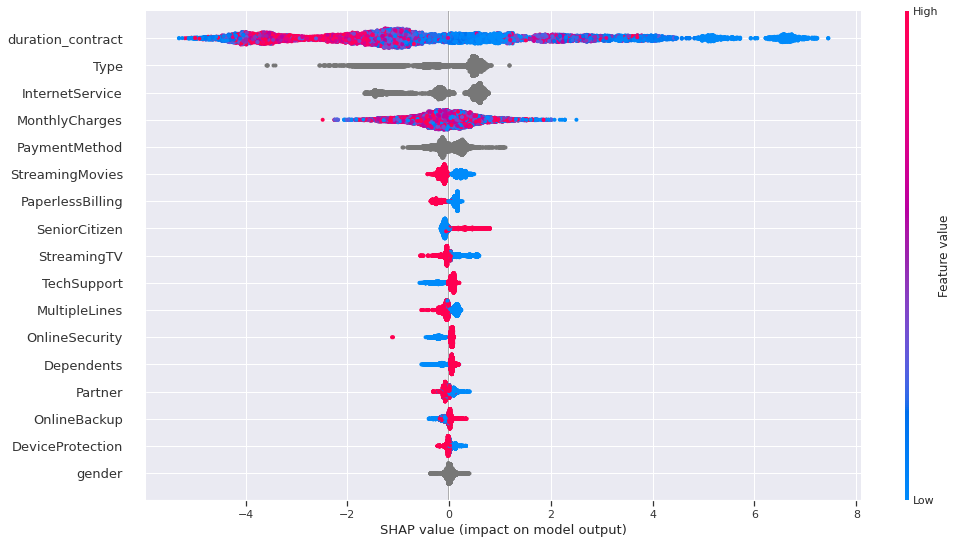

In [ ]:
shap.summary_plot(shap_values, features_train, plot_size=(16,9))

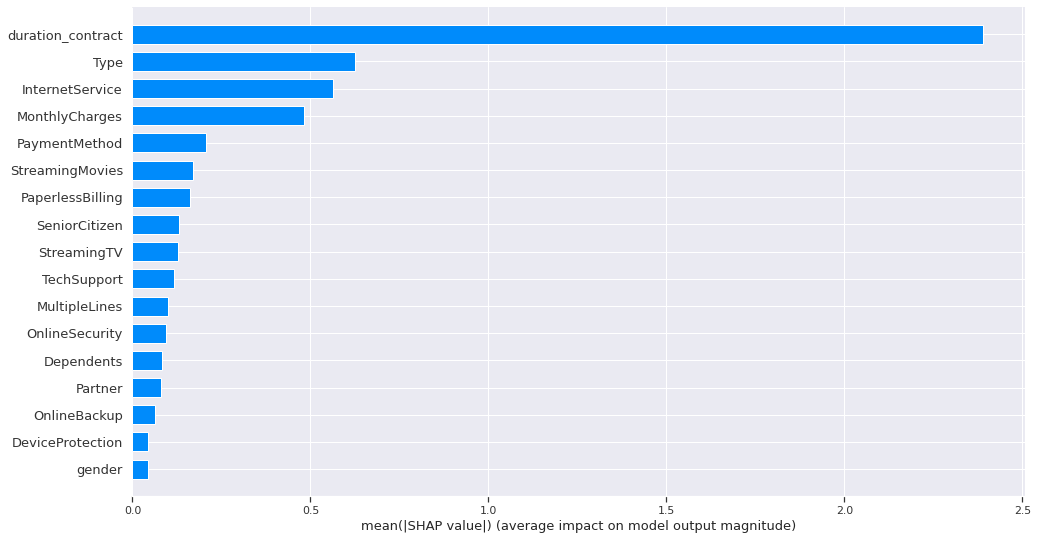

In [ ]:
shap.summary_plot(shap_values, features_train, plot_type="bar", plot_size=(16,9))

По графикам видим, что важные показатели: 
- Продолжительность контракта
- Тип оплаты
- Интернет сервис
- Ежемесячный платеж


# Отчёт

*  Мы загрузили и описали данные
*  Провели предобработку данных: нашли пропуски, заполнили их. Рассчитали длительность контрактов и добавили дополнительным признаком.
*  Создали целевой признак 0 - клиент с нами и  1- клиент расторгнул контракт
*  Соединили все таблицы в общую.
*  Заполнили пропущенные значению по услугам, как Нет.
*  Исследовали данные. Проверили числовые данные на нормальность и выяснили, что данные распредлены ненормально. Исследовали зависимости между признаками, чтобы зависимые признаки перед обучением моделей. Проверили гипотезу, которая подтвердила, что общие платежи клиентов с нами различаются от общих платежах клиентов расторгнувших контракт.
* Провели обучение классических моделей и моделей на основе градиентного бустинга с автоматическим подбором гиперпараметров.

- Наилучшую метрику качества показала модель CatBoost с показателями: 

 - roc_auc_score: 0.94
 - accuracy_score: 0.87

- Исследовали модель CatBoost на важные признаки. Наиболее важные признаки для бизнеса, которые характеризуют клиентов это: 
  - Продолжительность контракта
  - Тип оплаты
  - Интернет сервис
  - Ежемесячный платеж

